### Просмотр всех аугментаций на одном случайном изображении (5 вариантов)

Выбрано: ..\datasets\raw\school_notebooks_ru\images\97_978.jpg


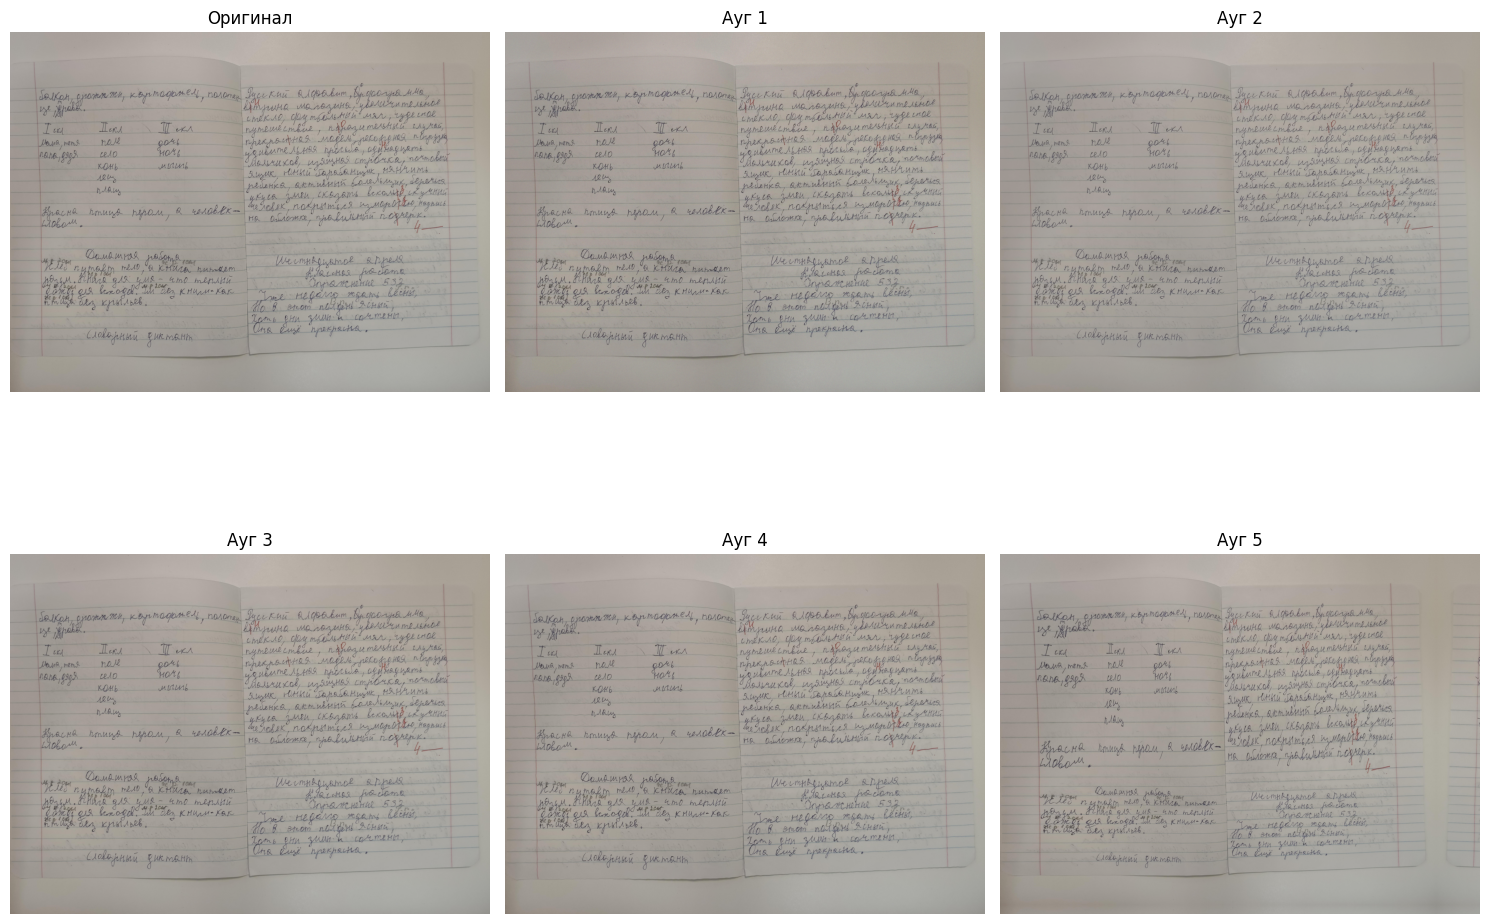

In [3]:
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from albumentations import (
    Compose, GaussNoise, RandomBrightnessContrast, MotionBlur,
    ElasticTransform, GridDistortion
)


RAW_DIRS = [
    "../datasets/raw/school_notebooks_ru/images",
    "../datasets/raw/hwr200/images",
]

# --- сильные аугментации ---
augmentations = [
    # 1. Добавление гауссовского шума
    # Усиливает зернистость изображения, имитирует "шум" камеры или плохое освещение.
    # var_limit=(20, 60) — диапазон дисперсии шума, 20→мягко, 60→заметно.
    Compose([GaussNoise(var_limit=(20, 60), p=1)]),

    # 2. Яркость и контраст
    # Легко затемняет/светлит изображение и делает цифры более или менее контрастными.
    # brightness_limit=0.20 → до ±20% изменения яркости.
    # contrast_limit=0.20 → до ±20% изменения контраста.
    Compose([
        RandomBrightnessContrast(
            brightness_limit=0.20,
            contrast_limit=0.20,
            p=1
        )
    ]),

    # 3. Motion blur (имитация движения)
    # Размазывает изображение в одном направлении — будто рука дрогнула.
    # blur_limit=9 → сильнее, чем дефолт, но безопасно (не стирает детали).
    Compose([
        MotionBlur(blur_limit=9, p=1)
    ]),

    # 4. Elastic deformation — "резиновое" искажение
    # Имитирует искажение листа, мятую бумагу, растяжение.
    # alpha=55, sigma=10, alpha_affine=10 — умеренно сильные параметры.
    Compose([
        ElasticTransform(
            alpha=55,
            sigma=10,
            alpha_affine=10,
            p=1
        )
    ]),

    # 5. GridDistortion — сеточная деформация
    # Делит изображение на сетку и искажает отдельные сегменты.
    # distort_limit=0.35 → сильная, но безопасная деформация.
    # num_steps=5 → сетка из 5×5 блоков.
    Compose([
        GridDistortion(
            num_steps=5,
            distort_limit=0.35,
            p=1
        )
    ]),
]

# выбрать случайное изображение
all_files = []
for p in RAW_DIRS:
    all_files += list(Path(p).glob("*.jpg"))
    all_files += list(Path(p).glob("*.JPG"))

img_path = random.choice(all_files)
print("Выбрано:", img_path)

image = cv2.imread(str(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# применяем аугментации
augmented = [aug(image=image)["image"] for aug in augmentations]

plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Оригинал")
plt.axis("off")

for i, img_aug in enumerate(augmented):
    plt.subplot(2, 3, i+2)
    plt.imshow(img_aug)
    plt.title(f"Ауг {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Обработка всех изображений в папке и сохранение новых (5×)

In [1]:
from pathlib import Path
import cv2
from albumentations import (
    Compose, GaussNoise, RandomBrightnessContrast,
    MotionBlur, ElasticTransform, GridDistortion
)
from multiprocessing import Pool, cpu_count
import os


# -----------------------------------------------------
# Пути (исправлены - относительные пути из папки notebooks)
# -----------------------------------------------------
RAW_DIRS = {
    "school": "../datasets/raw/school_notebooks_ru/images",
    "hwr": "../datasets/raw/hwr200/images",
}

OUT_DIRS = {
    "school": "../datasets/processed/school_notebooks_ru/images",
    "hwr": "../datasets/processed/hwr200/images",
}


# -----------------------------------------------------
# Аугментации
# -----------------------------------------------------
augmentations = [
    ("gauss", Compose([GaussNoise(var_limit=(20, 60), p=1)])),
    ("bright", Compose([RandomBrightnessContrast(0.20, 0.20, p=1)])),
    ("motion", Compose([MotionBlur(blur_limit=9, p=1)])),
    ("elastic", Compose([ElasticTransform(55, 10, 10, p=1)])),
    ("grid", Compose([GridDistortion(num_steps=5, distort_limit=0.35, p=1)])),
]


# -----------------------------------------------------
# Функция обработки 1 файла
# -----------------------------------------------------
def process_image(args):
    img_path, out_dir = args

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Ошибка чтения: {img_path}")
        return 0

    stem = img_path.stem
    ext = img_path.suffix.lower()

    try:
        for aug_name, aug in augmentations:
            aug_img = aug(image=img)["image"]
            output_path = out_dir / f"{stem}_{aug_name}{ext}"
            cv2.imwrite(str(output_path), aug_img)
        return 1
    except Exception as e:
        print(f"Ошибка при обработке {img_path}: {e}")
        return 0


# -----------------------------------------------------
# Подготовка списка задач
# -----------------------------------------------------
tasks = []
valid_ext = {".jpg", ".jpeg", ".png"}

for key in RAW_DIRS:
    in_dir = Path(RAW_DIRS[key])
    out_dir = Path(OUT_DIRS[key])
    
    # Убедимся, что папка существует
    out_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"Поиск изображений в: {in_dir}")
    print(f"Сохраняем в: {out_dir}")
    
    # Используем рекурсивный поиск для надежности
    images = []
    for ext in valid_ext:
        # Ищем файлы с разным регистром расширений
        images.extend(in_dir.glob(f"*{ext}"))
        images.extend(in_dir.glob(f"*{ext.upper()}"))
    
    # Удаляем дубликаты и проверяем, что файл читается
    unique_images = []
    for img_path in images:
        if img_path not in unique_images and cv2.imread(str(img_path)) is not None:
            unique_images.append(img_path)
            tasks.append((img_path, out_dir))
    
    print(f"Найдено изображений в {key}: {len(unique_images)}")

total = len(tasks)
print(f"\nВсего изображений для обработки: {total}")
print(f"Будет создано {total * len(augmentations)} аугментированных файлов")
print(f"CPU ядер доступно: {cpu_count()}\n")


# -----------------------------------------------------
# Упрощенная версия с отображением прогресса
# -----------------------------------------------------
def simple_processing():
    processed = 0
    for i, task in enumerate(tasks):
        result = process_image(task)
        processed += result
        
        # Выводим прогресс каждые 10 изображений
        if (i + 1) % 10 == 0 or (i + 1) == total:
            print(f"Обработано: {processed}/{total} изображений ({processed * len(augmentations)} файлов)")
    
    return processed


# -----------------------------------------------------
# Многопроцессорная версия с упрощенным прогрессом
# -----------------------------------------------------
def multiprocessing_processing():
    processed_count = 0
    
    def update_progress(result):
        nonlocal processed_count
        processed_count += result
        
        # Выводим прогресс каждые 10 обработанных изображений
        if processed_count % 10 == 0 or processed_count == total:
            print(f"Обработано: {processed_count}/{total} изображений ({processed_count * len(augmentations)} файлов)")
        
        return result

    print("Начинаем обработку с использованием многопроцессорности...")
    
    with Pool(min(cpu_count(), 4)) as pool:  # Ограничиваем количество процессов
        for result in pool.imap_unordered(process_image, tasks):
            update_progress(result)
    
    return processed_count


# -----------------------------------------------------
# Запуск обработки
# -----------------------------------------------------
if __name__ == "__main__":
    # Выберите один из методов:
    # 1. Простой последовательный (для отладки)
    print("Используем последовательную обработку для отладки...")
    final_count = simple_processing()
    
    # 2. Многопроцессорный (для производства)
    # print("Используем многопроцессорную обработку...")
    # final_count = multiprocessing_processing()
    
    print(f"\nОбработка завершена!")
    print(f"Успешно обработано: {final_count}/{total} изображений")
    print(f"Создано {final_count * len(augmentations)} аугментированных файлов")
    
    # Проверяем созданные файлы
    for key in OUT_DIRS:
        out_dir = Path(OUT_DIRS[key])
        created_files = list(out_dir.glob("*"))
        print(f"В {out_dir}: {len(created_files)} файлов")

Поиск изображений в: ..\datasets\raw\school_notebooks_ru\images
Сохраняем в: ..\datasets\processed\school_notebooks_ru\images
Найдено изображений в school: 1857
Поиск изображений в: ..\datasets\raw\hwr200\images
Сохраняем в: ..\datasets\processed\hwr200\images
Найдено изображений в hwr: 117

Всего изображений для обработки: 1974
Будет создано 9870 аугментированных файлов
CPU ядер доступно: 16

Используем последовательную обработку для отладки...
Обработано: 10/1974 изображений (50 файлов)
Обработано: 20/1974 изображений (100 файлов)
Обработано: 30/1974 изображений (150 файлов)
Обработано: 40/1974 изображений (200 файлов)
Обработано: 50/1974 изображений (250 файлов)
Обработано: 60/1974 изображений (300 файлов)
Обработано: 70/1974 изображений (350 файлов)
Обработано: 80/1974 изображений (400 файлов)
Обработано: 90/1974 изображений (450 файлов)
Обработано: 100/1974 изображений (500 файлов)
Обработано: 110/1974 изображений (550 файлов)
Обработано: 120/1974 изображений (600 файлов)
Обработа